In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Jakob S. Jørgensen (DTU)
#                Gemma Fardell (UKRI-STFC)
#                Edoardo Pasca (UKRI-STFC)     
#                Laura Murgatroyd (UKRI-STFC)
#                Margaret Duff (STFC - UKRI)
#                   

# Helsinki Tomography Challenge - Limited Angle CT Reconstruction 

This notebook takes you through TODO:

Learning objectives are:
- TODO:


In [16]:
# basic imports
import numpy as np
# method imports
from htc_code.helper_functions import *

from cil.utilities.display import show2D, show_geometry
from cil.recon import FDK

In [3]:

def preprocess(data):
    '''Preprocess the data'''
    # renormalise data
    data_renorm = util.correct_normalisation(data)
    # pad data
    data_pad = util.pad_zeros(data_renorm)
    # apply beam hardening correction
    data_BHC = util.apply_BHC(data_pad)
    return data_BHC

def segment(data, segment_type):
    '''Run segmentation on data with method segment_type'''
    if segment_type == 1:
        ss = util.apply_global_threshold(data)
    elif segment_type == 2:
        ss = util.apply_crazy_threshold(data)
    return util.flipud_unpack(ss)
 




In [5]:

# Load the data:
data = load_htc2022data("./htc_code/test_data/htc2022_ta_sparse_example.mat", dataset_name="CtDataLimited")

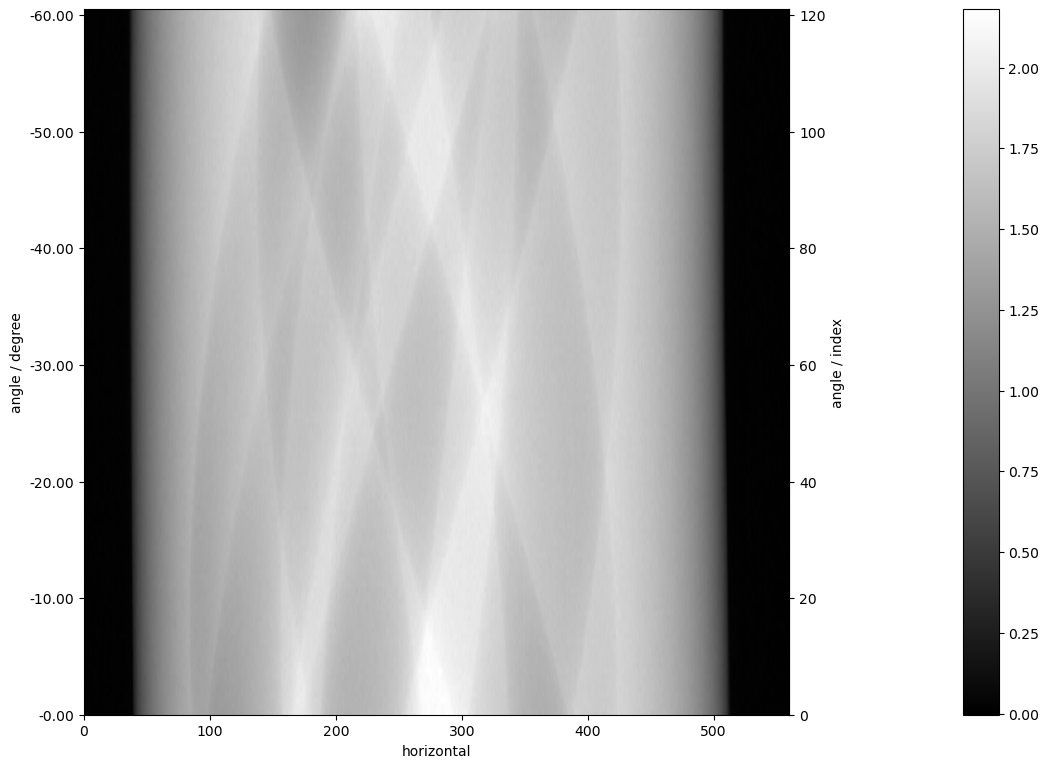

In [11]:
print(data.geometry)

2D Cone-beam tomography
System configuration:
	Source position: [   0.  , -410.66]
	Rotation axis position: [0., 0.]
	Detector position: [  0.  , 143.08]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [560   1]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 121
	Angles 0-9 in degrees: [-0. , -0.5, -1. , -1.5, -2. , -2.5, -3. , -3.5, -4. , -4.5]
	Angles 111-120 in degrees: [-55.5, -56. , -56.5, -57. , -57.5, -58. , -58.5, -59. , -59.5, -60. ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


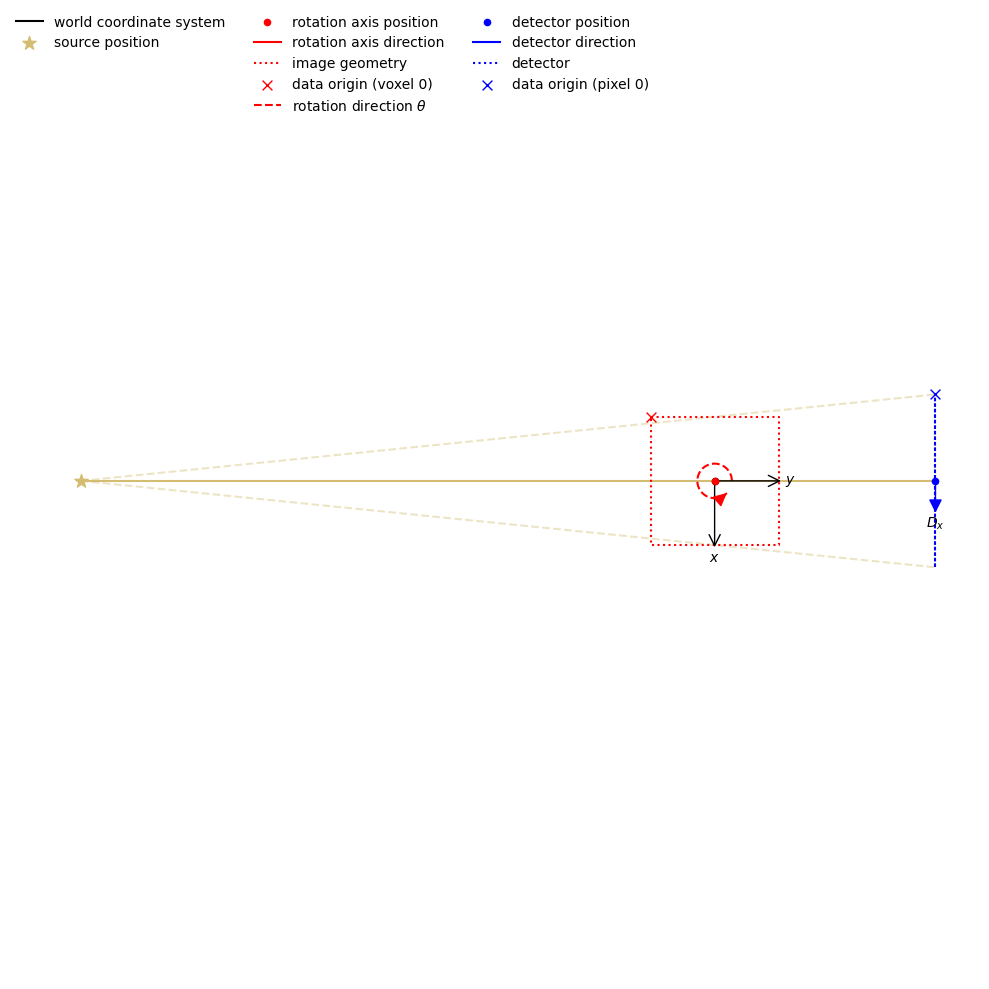

In [14]:
show_geometry(data.geometry)

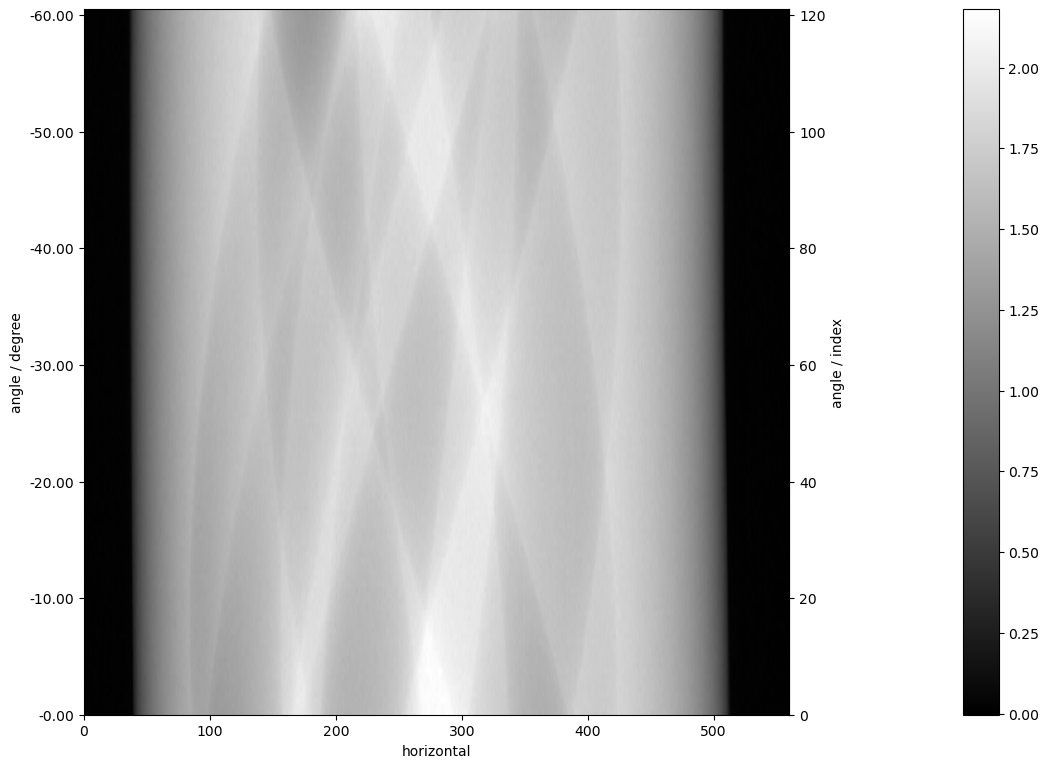

In [15]:
show2D(data)

FDK recon

Input Data:
	angle: 121
	horizontal: 560

Reconstruction Volume:
	horizontal_y: 560
	horizontal_x: 560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



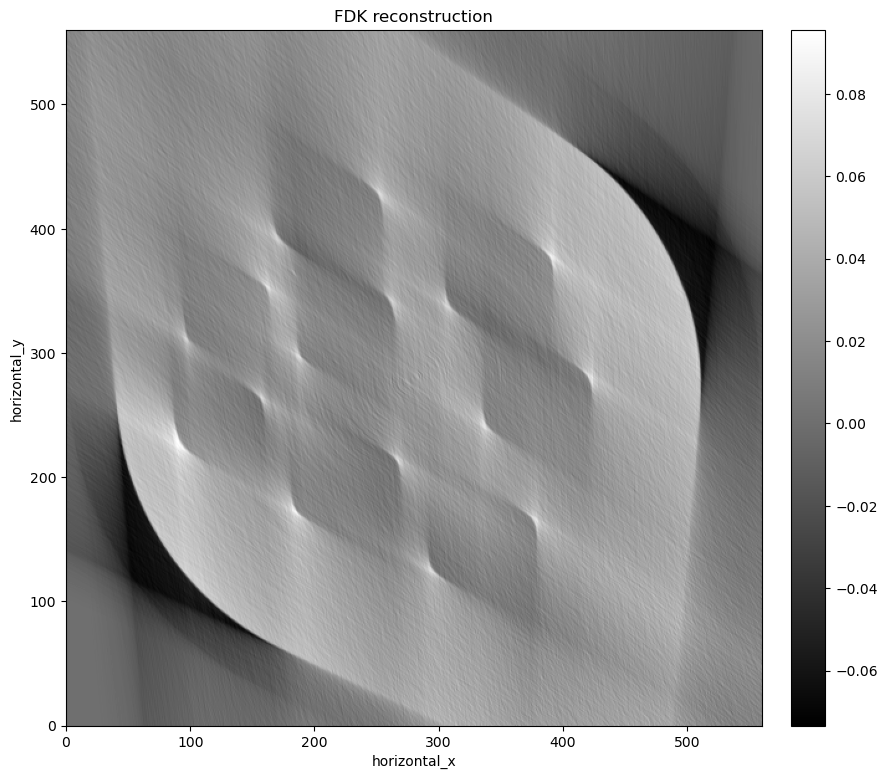

In [18]:
ig=data.geometry.get_ImageGeometry()
fdk =  FDK(data, ig)
recon = fdk.run()
show2D(recon, title='FDK reconstruction');

We see that the missing angles leads to

In [ ]:

###########################################################
# CONFIGURATION
# Image size
im_size = 512

# Upper bound mask
ub_val = 0.040859 # acrylic_attenuation in unit 1/mm
ub_mask_type = 2   # 1 basic 0.97 circle. 2 fitted
basic_mask_radius = 0.97

# Lower bound mask
lb_mask_type = 0   # 0:  lower bound 0 everywhere, 1: outer annulus equal to upper bound acrylic
lb_inner_radius = 200
lb_val = ub_val  # could be changed to 0.04 or other smaller values

# Reconstruction
alpha = 0.01
alpha_dx = 0.03

num_iters = 2000
update_objective_interval = 100
verbose = 1

# Segmentation
segmentation_method = 2  # 1 basic thresholding, 2 crazy

#####################################################





In [ ]:

input_files = glob.glob(os.path.join(glob.escape(input_folder),"*.mat"))
if input_files == []:
    raise Exception(f"No input files found, looking in folder '{input_folder}' for files with extension '.mat'")






# Preprocess
data_preprocessed = preprocess(data)
# discover angular range
ang_range = np.abs(data_preprocessed.geometry.angles[-1]-data_preprocessed.geometry.angles[0])
omega = 90.0/ang_range

ig = data_preprocessed.geometry.get_ImageGeometry()
ig.voxel_num_x = im_size
ig.voxel_num_y = im_size

# NOTE: the fit of the sample mask works best with the non pre-processed data
# as the FDK reconstruction is more blurry!!!
lb, ub = create_lb_ub(data, ig, ub_mask_type, lb_mask_type, 
                        ub_val, lb_val, basic_mask_radius, lb_inner_radius)


# algorithmic parameters
args = [omega, alpha, alpha_dx]

# Run reconstruction
data_recon = pdhg_rotate_isotv_anisotv(data_preprocessed, ig, lb, ub, *args, num_iters=num_iters, 
        update_objective_interval=update_objective_interval, verbose=verbose)

data_segmented = segment(data_recon, segmentation_method)

util.write_data_to_png(data_segmented, input_file, output_folder)




In [5]:
def create_lb_ub(data, ig, ub_mask_type, lb_mask_type, ub_val, lb_val, basic_mask_radius, lb_inner_radius):
    # create default lower bound mask
    lb = ig.allocate(0.0)
    # create upper bound mask
    if ub_mask_type == 1:
        ub = ig.allocate(ub_val)
        ub = util.apply_circular_mask(ub, basic_mask_radius)
    elif ub_mask_type == 2:
        # sample mask with upper bound to acrylic attenuation
        ub = ig.allocate(0)
        circle_parameters = util.find_circle_parameters(data, ig)
        util.fill_circular_mask(circle_parameters, ub.array, \
            ub_val, *ub.shape)
        # create lower bound mask annulus if needed
        if lb_mask_type == 1:
            inner_circle_parameters = circle_parameters.copy()
            inner_circle_parameters[0] = lb_inner_radius
            util.fill_circular_mask(circle_parameters, lb.array, lb_val, *ub.shape)
            inner = ig.allocate(0.0)
            util.fill_circular_mask(inner_circle_parameters, inner.array, 1.0, *ub.shape)
            lb.array[inner.array.astype(bool)==1.0] = 0.0

    return lb, ub

In [6]:

class IndicatorBoxPixelwise(Function):
    def __init__(self,lower,upper):
        '''creator
        :param lower: lower bound
        :type lower: float, default = :code:`-numpy.inf`
        :param upper: upper bound
        :type upper: float, optional, default = :code:`numpy.inf`
        '''
        super(IndicatorBoxPixelwise, self).__init__()
        self.lower = lower
        self.upper = upper
    
    def __call__(self,x):
        '''Evaluates IndicatorBox at x'''
        if (np.all(x.as_array() >= self.lower.as_array()) and 
            np.all(x.as_array() <= self.upper.as_array()) ):
            val = 0
        else:
            val = np.inf
        return val
    
    def proximal(self, x, tau, out=None):
        r'''Proximal operator of IndicatorBox at x
            .. math:: prox_{\tau * f}(x)
        '''
        if out is None:
            return (x.maximum(self.lower)).minimum(self.upper)        
        else:               
            x.maximum(self.lower, out=out)
            out.minimum(self.upper, out=out) 

    def convex_conjugate(self,x):
        '''Convex conjugate of IndicatorBox at x'''
        return x.maximum(0).sum()


def pdhg_tv(data, ig, lb, ub, *args, num_iters=100, update_objective_interval=100, verbose=1):
    omega = args[0]
    alpha = args[1]
    
    Grad = GradientOperator(ig)
    A = ProjectionOperator(ig, data.geometry)
    Id = IdentityOperator(ig)
    K = BlockOperator(A, Grad)

    f1 = omega*L2NormSquared(b=data)
    f2 = alpha*MixedL21Norm()
    F = BlockFunction(f1, f2)
    
    G = IndicatorBoxPixelwise(lower=lb, upper=ub)

    normK = K.norm()
    sigma = 1.0
    tau = 1.0/(sigma*normK**2)

    algo = PDHG(initial=ig.allocate(0.0),
                f=F, g=G, operator=K, 
                sigma=sigma, tau=tau,
                update_objective_interval=100, 
                max_iteration=num_iters)
    algo.run(verbose=verbose)
    return algo.solution.copy()


def pdhg_rotate_isotv_anisotv(data, ig, lb, ub, *args, num_iters=100, update_objective_interval=100, verbose=1):
    
    ag_rotated = data.geometry.copy()
    
    ang_middle = (data.geometry.angles[0]+data.geometry.angles[-1])/2
    #ang_start = np.abs(data.geometry.angles[0])
    #ang_range = np.abs(data.geometry.angles[-1]-data.geometry.angles[0])
    #ang_rotate = (ang_start+ang_range/2.0)
    ag_rotated.set_angles(data.geometry.angles - ang_middle, angle_unit='degree')
    
    data = AcquisitionData(data.as_array(), geometry=ag_rotated)
    
    omega = args[0]
    alpha = args[1]
    alpha_dx = args[2]
    
    Grad = GradientOperator(ig)
    A = ProjectionOperator(ig, data.geometry)
    Dx = FiniteDifferenceOperator(ig, direction='horizontal_x')
    K12x = BlockOperator(A, Grad, Dx)

    f1 = omega*L2NormSquared(b=data)
    f2 = alpha*MixedL21Norm()
    f_dx = alpha_dx*L1Norm()
    F12x = BlockFunction(f1, f2, f_dx)
    
    lb_copy = lb.copy()
    ub_copy = ub.copy()
    lb_copy.array = rotate(lb.as_array(), -ang_middle)
    ub_copy.array = rotate(ub.as_array(), -ang_middle)

    G = IndicatorBoxPixelwise(lower=lb_copy, upper=ub_copy)

    normK = K12x.norm()
    sigma = 1.0
    tau = 1.0/(sigma*normK**2)

    algo = PDHG(initial=ig.allocate(0.0),
                f=F12x, g=G, operator=K12x, 
                sigma=sigma, tau=tau,
                update_objective_interval=update_objective_interval, 
                max_iteration=num_iters)
    algo.run(verbose=verbose)
    
    sol =  algo.solution.copy()
    sol.array = rotate(sol.as_array(), ang_middle)
    return sol



def pdhg_l1tvl1(data, ig, lb, ub, *args, num_iters=2000, update_objective_interval=100, verbose=1):
    omega = args[0]
    alpha = args[1]
    beta = args[2]
    
    Grad = GradientOperator(ig)
    A = ProjectionOperator(ig, data.geometry)
    Id = IdentityOperator(ig)
    K = BlockOperator(A, Grad, Id)
    
    f1 = omega*L1Norm(b=data)
    f2 = alpha*MixedL21Norm()
    f3 = beta*L1Norm()
    F = BlockFunction(f1, f2, f3)
    G = IndicatorBoxPixelwise(lower=lb, upper=ub)
    
    normK = K.norm()
    sigma = 1.0
    tau = 1.0/(sigma*normK**2)
    algo = PDHG(initial=ig.allocate(0.0),
        f=F, g=G, operator=K,
        sigma=sigma, tau=tau,
        update_objective_interval=update_objective_interval, max_iteration=num_iters)
    algo.run(verbose=verbose)
    return algo.solution.copy()


def TV_iso_and_aniso_PDHG(preproc_data, fidelity_weight=10, 
                          iso_weight = 1.0,
                          aniso_weight_y = 1.0,
                          aniso_weight_x = 1.0, lower = 0.0, upper = 0.04, init_recon = None,
                          max_iterations = 1000, update_objective_interval = 100, verbose=1, imsize=None):
        
    # image geometry
    ig = preproc_data.geometry.get_ImageGeometry()
    
    if imsize is not None:
        ig.voxel_num_x = imsize
        ig.voxel_num_y = imsize    
    
    if init_recon is None:
        init_recon = ig.allocate()    
    
    # FinDiff operators in y, x (numpy)
    DY = FiniteDifferenceOperator(ig, direction=0)
    DX = FiniteDifferenceOperator(ig, direction=1)
    
    # GradOperar with c backend
    Grad = GradientOperator(ig)
    
    
    # PDHG operator
    A = ProjectionOperator(ig, preproc_data.geometry)
    K = BlockOperator(A, DY, DX, Grad)
    
    # PDHG composite part
    f1 = (fidelity_weight/2)*L2NormSquared(b=preproc_data)
    f2 = aniso_weight_y*L1Norm() #0.05
    f3 = aniso_weight_x*L1Norm()
    f4 = -iso_weight * MixedL21Norm()
    F = BlockFunction(f1, f2, f3, f4)
    
    # PDHG no composite part
    #G = IndicatorBox(lower=lower, upper=upper)
    G = IndicatorBoxPixelwise(lower=lower, upper=upper)

    normK = K.norm()
    
    sigma = 0.1
    tau = 1./(sigma*normK**2)
    
    pdhg_anis_iso = PDHG(initial=init_recon,f=F, g=G, operator=K, 
                update_objective_interval=update_objective_interval,
                sigma=sigma, tau=tau,
               max_iteration=max_iterations)
    pdhg_anis_iso.run(verbose=verbose)    
    
    return pdhg_anis_iso.solution.copy()


NameError: name 'Function' is not defined